In [4]:
import pandas as pd
import os
import pickle
import numpy as np
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import wkt
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Functions

In [3]:
def plot_comparison_maps(df, col1, col2, title1, title2):
    fig, ax = plt.subplots(1, 2, figsize  = (15, 12))
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    df.plot(column = col1, 
            ax = ax[0], 
            figsize = (10, 10))
    ax[0].set_title(title1)
    df.plot(column = col2, 
            ax = ax[1], 
            figsize = (10, 10),
             legend=True,
            legend_kwds={'orientation': "vertical"},
            cax = cax)
    ax[1].set_title(title2)

### Load Data

In [5]:
data_dir = '/Users/saraprice/Documents/NYU/Research/EV Charging Stations/Data'

In [6]:
##EV Charging stations data
EV_df = pd.read_csv(os.path.join(data_dir, 'EV_Charging_Stations_NYC_Open_Data.csv'))
#Zip code boundaries (GIS data for plotting)
zip_boundaries = gpd.read_file(os.path.join(data_dir, 'ZIP_CODE_040114', 'ZIP_CODE_040114.shp'))
#Reference file for NYC zip codes
NYC_zips = pd.read_csv(os.path.join(data_dir, 'NYC_zip_codes.csv'))
#Median income data
income_data = pd.read_csv(os.path.join(data_dir, 'median_income.csv'))
#Poverty data
poverty_data = pd.read_csv(os.path.join(data_dir, 'poverty_census_data_clean.csv'))
#Demo data
demo_data = pd.read_csv(os.path.join(data_dir, 'demo_data_acs_5yr_clean.csv'))

In [7]:
NYC_zips['borough'].unique()

array(['Manhattan', 'Staten', 'Bronx', 'Queens', 'Brooklyn'], dtype=object)

In [8]:
NYC_zips = NYC_zips.iloc[:,0:2]
NYC_zips['zip_code'] = NYC_zips['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
manhattan_zips = NYC_zips[NYC_zips['borough']=='Manhattan']
manhattan_zips.drop_duplicates(inplace = True)
manhattan_zips.shape

(96, 2)

In [9]:
##Clean up EV data
EV_df = EV_df[['Station Name', 'Street Address', 'City', 'ZIP']]
EV_df.rename(columns = {"Station Name": 'station_name',
                        "Street Address":'str_address',
                        "City": 'city',
                        'ZIP': 'zip_code'}, inplace = True)
EV_df['zip_code'] = EV_df['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))

In [10]:
EV_by_zip = EV_df[['station_name', 'zip_code']].groupby(['zip_code']).count().reset_index()\
                    .rename(columns = {'station_name':'station_count'})
EV_by_zip.shape

(104, 2)

In [11]:
#Add in all zip codes in NYC
EV_by_zip = EV_by_zip.merge(manhattan_zips, on = ['zip_code'])
print(EV_by_zip.shape)

(40, 3)


In [12]:
manhattan_zips[~manhattan_zips.zip_code.isin(NYC_zips.zip_code)]

,zip_code,borough


In [13]:
#limit to just incomes in NYC
income_data['zip_code'] = income_data['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
incomes_nyc = income_data[income_data.zip_code.isin(manhattan_zips.zip_code)].dropna()
print(incomes_nyc.head())
print(incomes_nyc.shape)
incomes_nyc['families_median_income'] = np.where(incomes_nyc['families_median_income']=='250,000+', 250000, 
                                             incomes_nyc['families_median_income'])
incomes_nyc = incomes_nyc[incomes_nyc['families_median_income']!='-']
incomes_nyc['families_median_income'] = incomes_nyc['families_median_income'].astype(int)
incomes_nyc.shape

  zip_code families_median_income
1    10001                 122776
2    10002                  40045
3    10003                 183787
4    10004                 205202
5    10005                 241094
(67, 2)


(43, 2)

### Combine Median Income Data

In [14]:
print(EV_by_zip.shape)
print(incomes_nyc.shape)
EV_income = pd.merge(EV_by_zip, incomes_nyc, on = 'zip_code')
print(EV_income.shape)
EV_income['families_median_income'] = EV_income['families_median_income'].fillna(0)
#EV_income['station_count'] = EV_income['station_count'].fillna(0)

(40, 3)
(43, 2)
(36, 4)


In [15]:
EV_income.corr()

,station_count,families_median_income
station_count,1.000000,0.426753
families_median_income,0.426753,1.000000


In [16]:
EV_income.sort_values('families_median_income', inplace = True)

Text(0.5, 1.0, 'Number of Charging Stations v. Family Median Income')

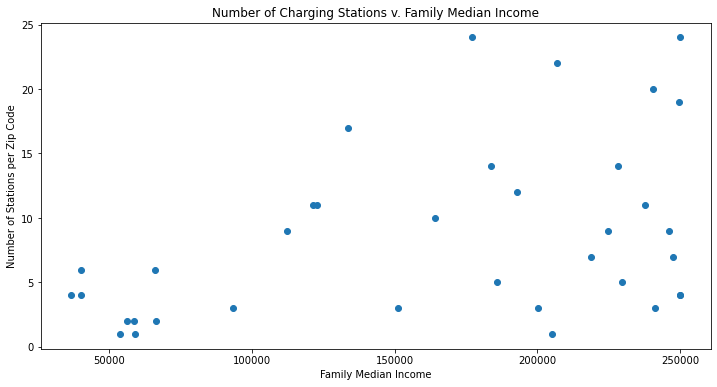

In [17]:
fig = plt.figure(figsize = (12, 6))
plt.scatter(EV_income['families_median_income'], EV_income['station_count'])
plt.xlabel("Family Median Income")
plt.ylabel("Number of Stations per Zip Code")
plt.title("Number of Charging Stations v. Family Median Income")

In [18]:
zip_boundaries['zip_code'] = zip_boundaries['ZIPCODE'].astype(str).apply(lambda x: str.zfill(x, 5))
EV_income_geo = EV_income.merge(zip_boundaries[['zip_code', 'geometry']], on = 'zip_code')
EV_income_geo = gpd.GeoDataFrame(EV_income_geo)
EV_income_geo.shape
EV_income_geo.head()

,zip_code,station_count,borough,families_median_income,geometry
0,10035,4,Manhattan,36645,"POLYGON ((1002726.933 233382.617, 1002745.950 ..."
1,10035,4,Manhattan,36645,"POLYGON ((1004345.970 230161.749, 1004358.650 ..."
2,10029,4,Manhattan,39845,"POLYGON ((999072.831 230985.376, 999519.721 23..."
3,10002,6,Manhattan,40045,"POLYGON ((991339.870 207576.784, 991330.490 20..."
4,10030,1,Manhattan,53586,"POLYGON ((1001899.622 238190.410, 1001839.062 ..."


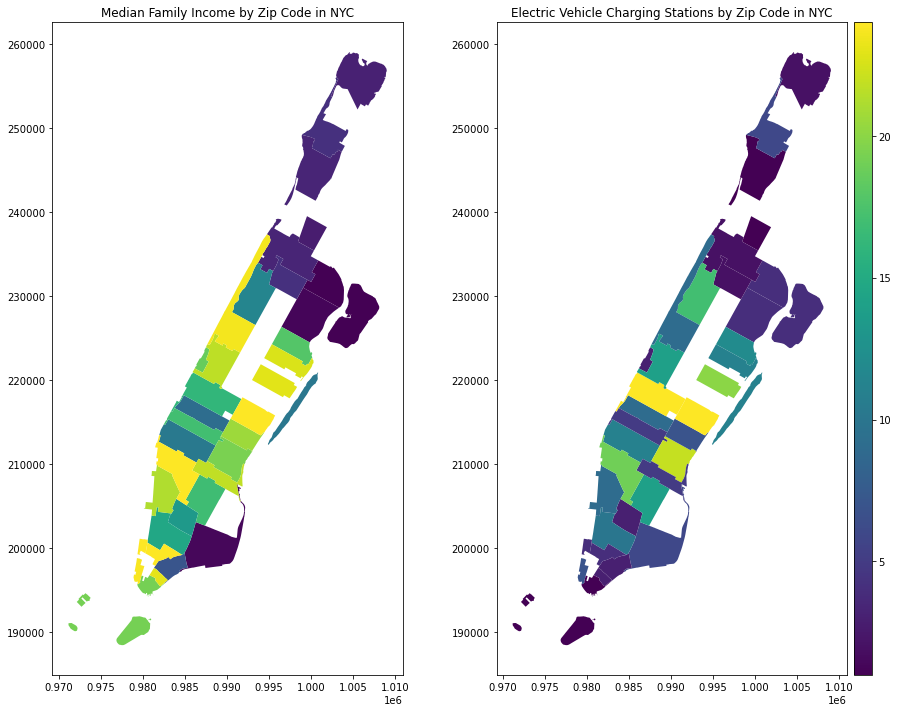

In [19]:
plot_comparison_maps(EV_income_geo, 'families_median_income', 'station_count', 
                     "Median Family Income by Zip Code in NYC", 
                     "Electric Vehicle Charging Stations by Zip Code in NYC")

### Poverty Rate Analysis

In [20]:
poverty_data['zip_code'] = poverty_data['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
poverty_nyc = pd.merge(poverty_data, manhattan_zips, on = 'zip_code')
print(poverty_nyc.shape)

(67, 5)


In [21]:
print(EV_by_zip.shape)
print(poverty_nyc.shape)
EV_poverty = pd.merge(poverty_nyc, EV_by_zip, on = 'zip_code')
EV_poverty['poverty_rate'] = EV_poverty['poverty_rate'].fillna(0)
EV_poverty['non_poverty_rate'] = 1- EV_poverty['poverty_rate']
EV_poverty['station_count'] = EV_poverty['station_count'].fillna(0)
print(EV_poverty.shape)

(40, 3)
(67, 5)
(37, 8)


In [22]:
EV_poverty.corr()

,count_poverty_level_determined,count_below_poverty_level,poverty_rate,station_count,non_poverty_rate
count_poverty_level_determined,1.000000,0.750858,0.454961,0.336171,-0.454961
count_below_poverty_level,0.750858,1.000000,0.845658,-0.148900,-0.845658
poverty_rate,0.454961,0.845658,1.000000,-0.316485,-1.000000
station_count,0.336171,-0.148900,-0.316485,1.000000,0.316485
non_poverty_rate,-0.454961,-0.845658,-1.000000,0.316485,1.000000


In [24]:
EV_poverty_geo = EV_poverty.merge(zip_boundaries[['zip_code', 'geometry']], on = 'zip_code')
EV_poverty_geo = gpd.GeoDataFrame(EV_poverty_geo)

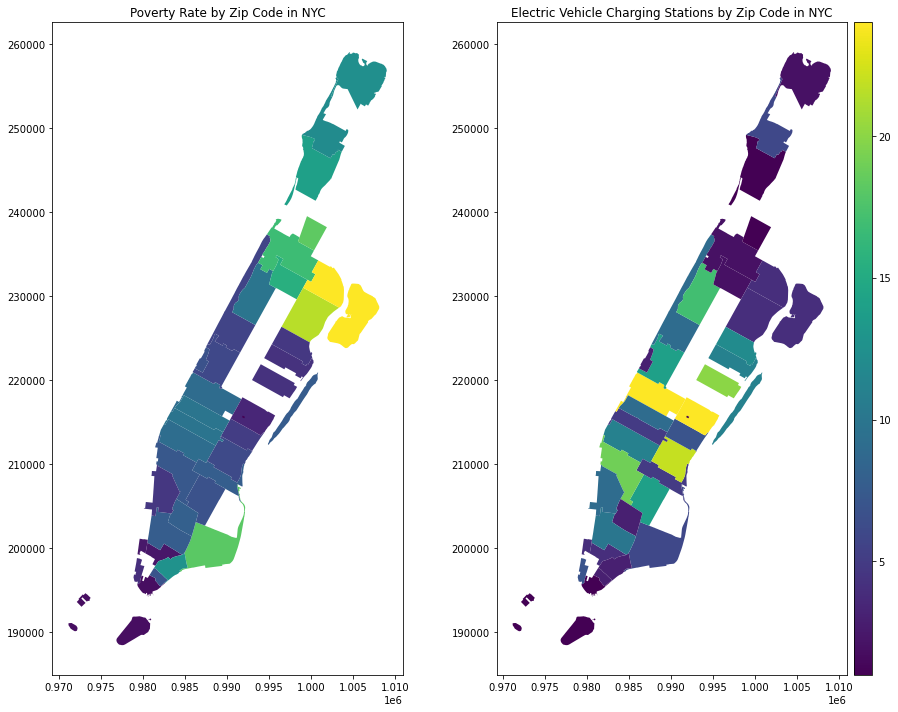

In [25]:
plot_comparison_maps(EV_poverty_geo, 'poverty_rate', 'station_count', 
                    "Poverty Rate by Zip Code in NYC",
                    "Electric Vehicle Charging Stations by Zip Code in NYC")


### Racial Demography Analysis

In [26]:
demo_data['zip_code'] = demo_data['zip_code'].astype(str).apply(lambda x: str.zfill(x, 5))
demo_nyc = pd.merge(demo_data, manhattan_zips, on = 'zip_code') 
demo_nyc.shape

(67, 13)

In [27]:
EV_demo = pd.merge(demo_nyc, EV_by_zip, on = 'zip_code', how = 'outer')
EV_demo = EV_demo.fillna(0)
EV_demo.shape

(70, 15)

In [28]:
EV_demo.drop([col for col in EV_demo.columns if col.find("pop")>0], inplace = True, axis = 1)
EV_demo.corr() 

,white_perc,black_perc,native_american_perc,asian_perc,hispanic_perc,station_count
white_perc,1.000000,-0.063394,0.174224,0.593383,0.164812,0.637510
black_perc,-0.063394,1.000000,0.359948,-0.017244,0.521663,-0.088568
native_american_perc,0.174224,0.359948,1.000000,0.238751,0.720739,0.251632
asian_perc,0.593383,-0.017244,0.238751,1.000000,0.076437,0.439097
hispanic_perc,0.164812,0.521663,0.720739,0.076437,1.000000,0.049171
station_count,0.637510,-0.088568,0.251632,0.439097,0.049171,1.000000


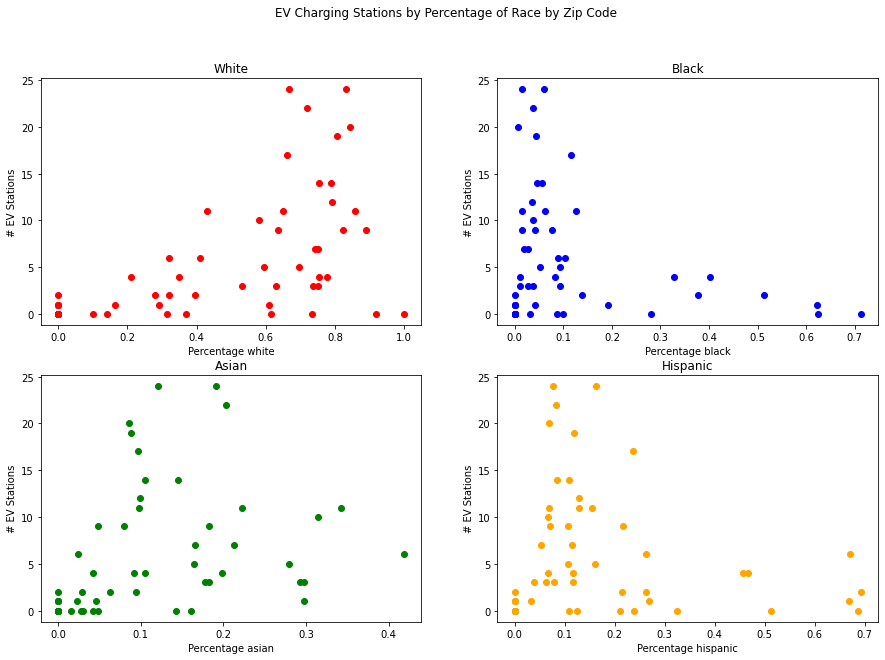

In [29]:
axs = {}
races = ['white', 'black', 'asian', 'hispanic']
fig, ((axs[0], axs[1]), (axs[2], axs[3])) = plt.subplots(2,2, figsize = (15,10))
fig.suptitle("EV Charging Stations by Percentage of Race by Zip Code")
i = 0
colors = ['red', 'blue', 'green', 'orange']
for race in races:
    axs[i].scatter(EV_demo[f'{race}_perc'], EV_demo['station_count'], color = colors[i])
    axs[i].set(ylabel = '# EV Stations', xlabel = f"Percentage {race}", title = "{}".format(str.title(race)))
    i+=1

In [30]:
print(EV_demo.columns)
print(zip_boundaries.columns)
EV_demo_geo = EV_demo.merge(zip_boundaries[['zip_code', 'geometry']], on = 'zip_code')

EV_demo_geo = gpd.GeoDataFrame(EV_demo_geo)

Index(['zip_code', 'white_perc', 'black_perc', 'native_american_perc',
       'asian_perc', 'hispanic_perc', 'borough_x', 'station_count',
       'borough_y'],
      dtype='object')
Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'zip_code'],
      dtype='object')


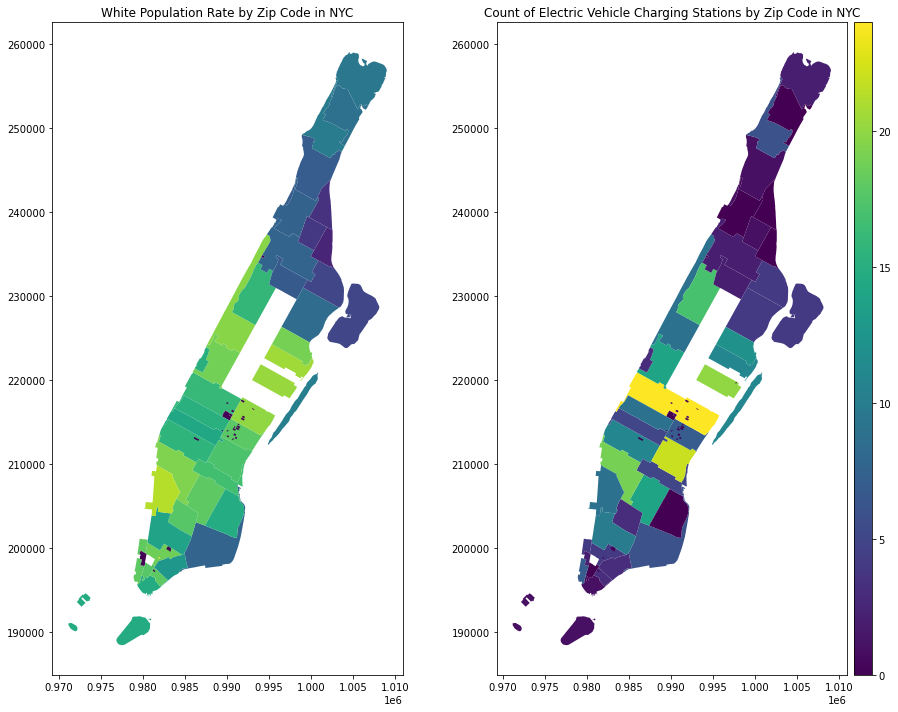

In [34]:
plot_comparison_maps(EV_demo_geo, 'white_perc', 'station_count', 
                     "White Population Rate by Zip Code in NYC", 
                     "Count of Electric Vehicle Charging Stations by Zip Code in NYC")

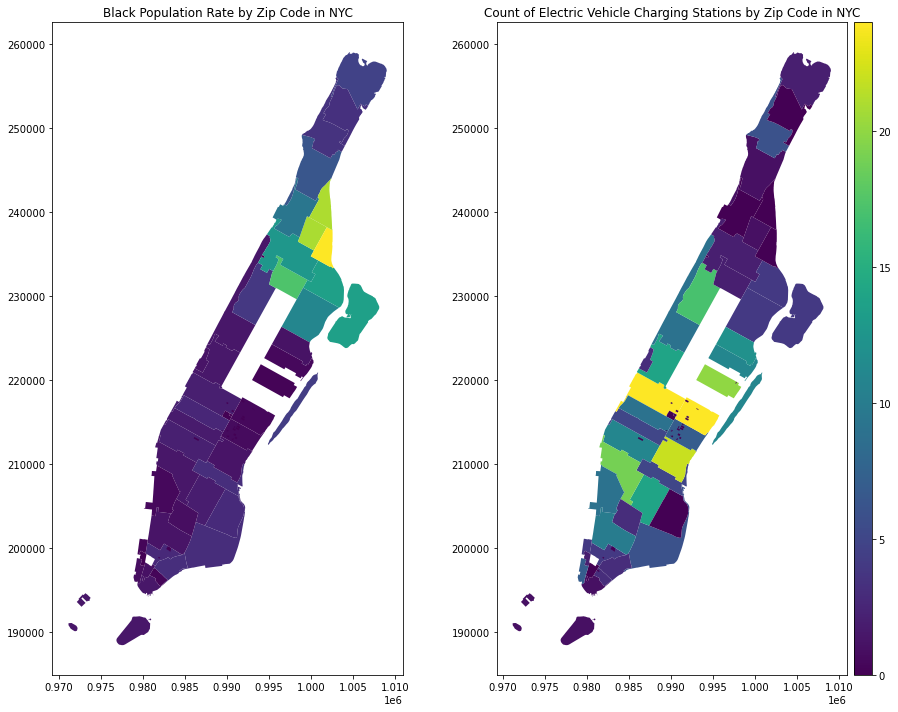

In [31]:
plot_comparison_maps(EV_demo_geo, 'black_perc', 'station_count', 
                     "Black Population Rate by Zip Code in NYC", 
                     "Count of Electric Vehicle Charging Stations by Zip Code in NYC")

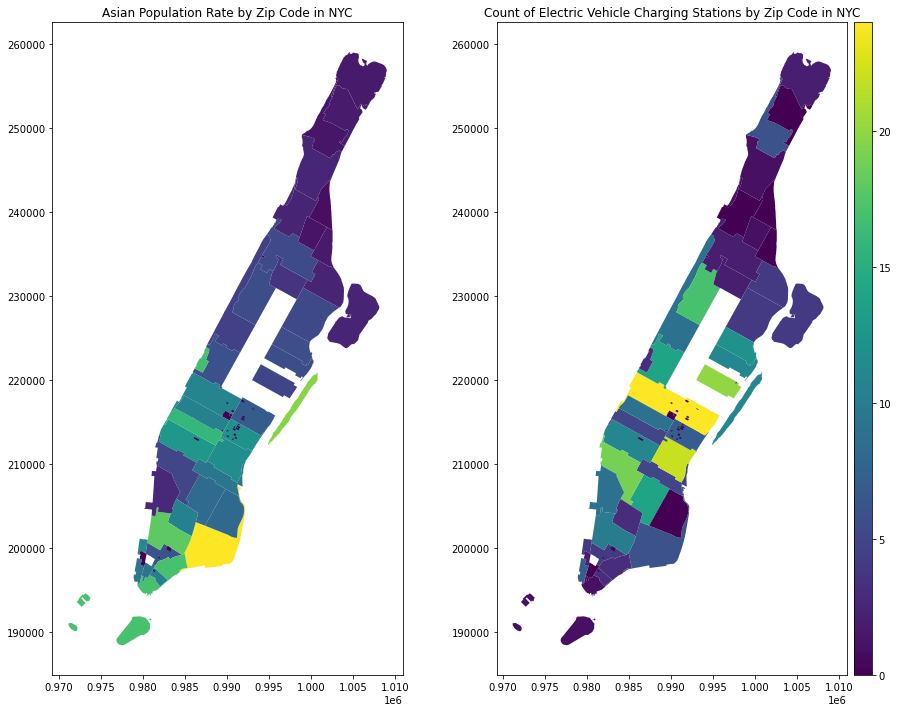

In [32]:
plot_comparison_maps(EV_demo_geo, 'asian_perc', 'station_count', 
                     "Asian Population Rate by Zip Code in NYC", 
                     "Count of Electric Vehicle Charging Stations by Zip Code in NYC")

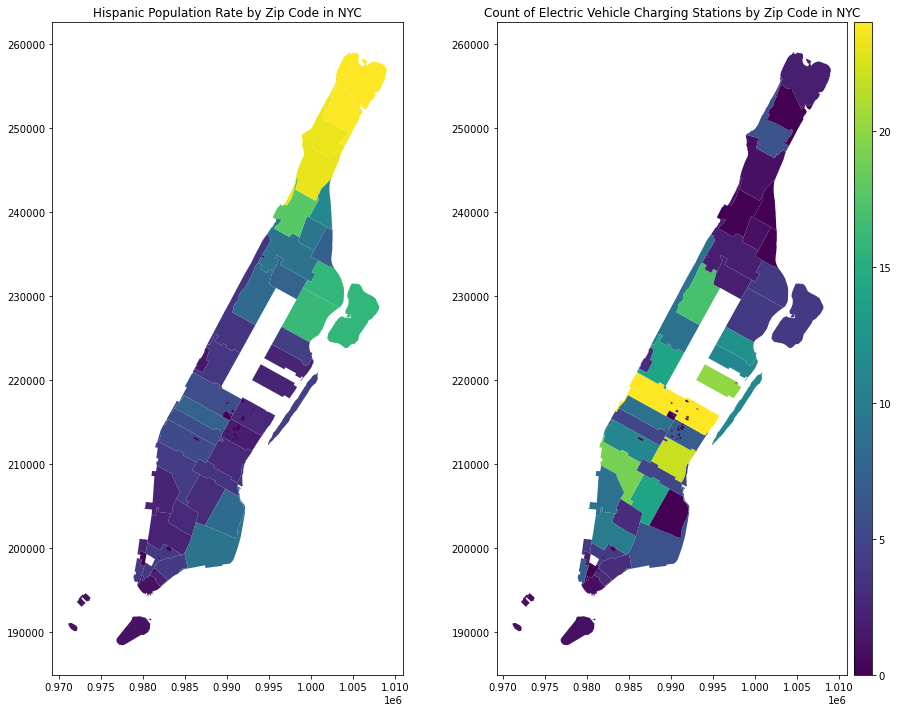

In [33]:
plot_comparison_maps(EV_demo_geo, 'hispanic_perc', 'station_count', 
                     "Hispanic Population Rate by Zip Code in NYC", 
                     "Count of Electric Vehicle Charging Stations by Zip Code in NYC")